# WHAT TO DO
- 번역 추론 결과물을 얻는 시간을 최적화

# WHAT I DID
1. 원본 리뷰 데이터 전처리: 중복을 최대한 제거하여 총 추론 생성 시간 단축
2. 데이터 분포 확인: 추론 데이터 분배를 위한 확인
3. 각 pc에서 추론 시간 비교: desktop, mini-pc, iMac

In [1]:
import pandas as pd

from typing import List
from pprint import pprint
import time
import socket

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")  # 기본 테마 설정 (다른 옵션: darkgrid, white, dark, ticks)

[결과1] 원본 리뷰 데이터 전처리

In [2]:
target_cols = ['review_comment_title', "review_comment_message"]

In [3]:
origin_review_df = pd.read_csv("../../downloads/olist/olist_order_reviews_dataset.csv")
print("Size of original reviews:", origin_review_df.shape)

pp_review_df = pd.read_csv("../../translate/artifact/preprocessed_reviews.csv")
print("Size of preprocessed reviews:", pp_review_df.shape)

Size of original reviews: (99224, 7)
Size of preprocessed reviews: (42609, 3)


[결과2] 데이터 분포 확인

In [4]:
def show_dist(df_:pd.DataFrame, target_cols:List):
    for col in target_cols:
        unique_values = df_[[col]].dropna()
        unique_values['len'] = unique_values[col].str.len()
        data_to_plot = unique_values.groupby('len').count()

        plt.figure(figsize=(15, 4))
        sns.barplot(x=data_to_plot.index, y=col, data=data_to_plot)
        plt.title(f"Distribution of unique {col}")
        plt.xlabel(f'Length of {col}')
        plt.ylabel(f'Count of {col}')
        plt.xticks(rotation=0)
        if len(data_to_plot) > 40:
            plt.xticks(range(unique_values['len'].min(), unique_values['len'].max(), 20))
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

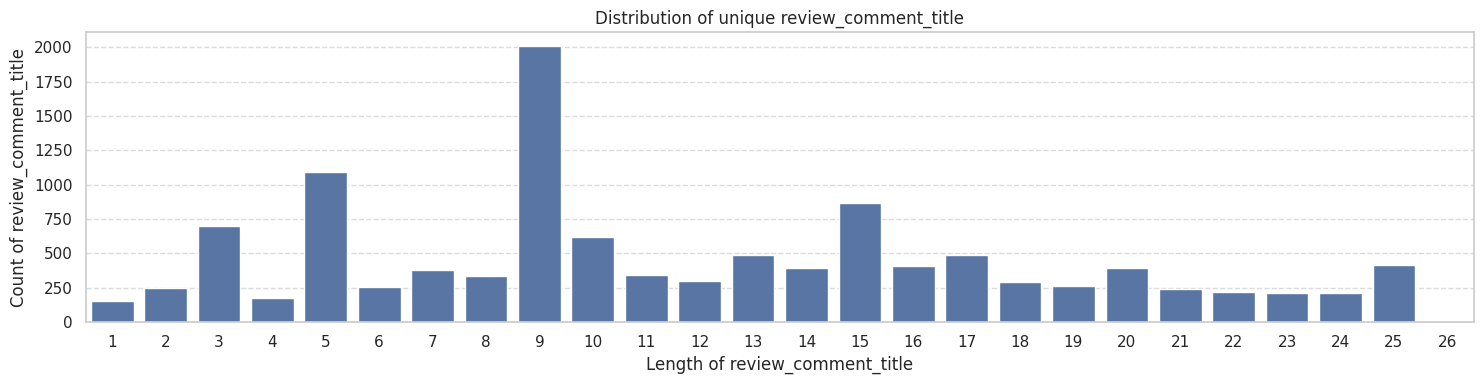

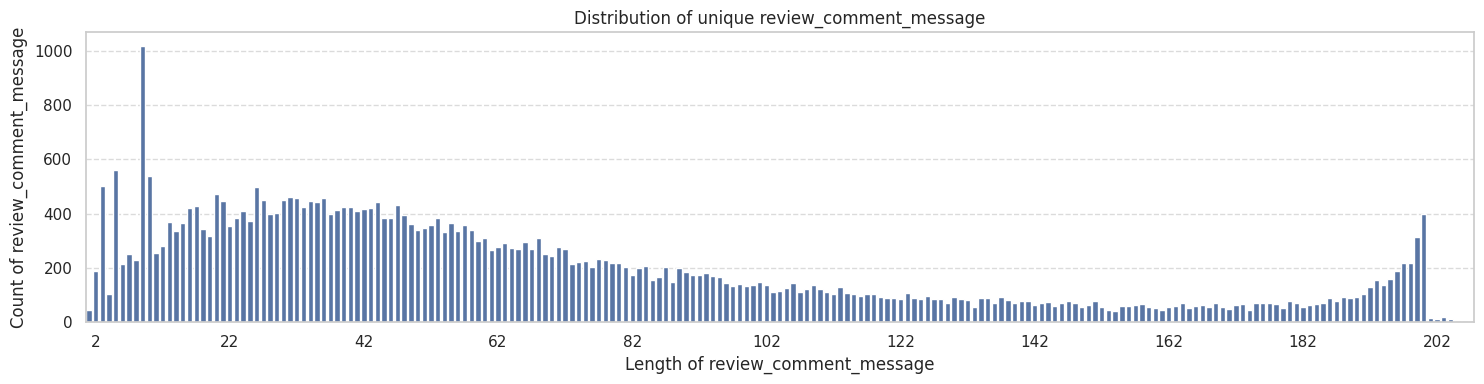

In [5]:
show_dist(pp_review_df, target_cols)

[결과3] 각 pc에서 추론 시간 비교: desktop, mini-pc, iMac

In [6]:
for col in target_cols:
    unique_values = pp_review_df[[col]].dropna()
    unique_values['len'] = unique_values[col].str.len()
    print(f"For '{col}'")
    print(f"- max len: {unique_values['len'].max()}")
    print(f"- median len: {unique_values['len'].median()}")
    print(f"- min len: {unique_values['len'].min()}")
    print()

For 'review_comment_title'
- max len: 26
- median len: 10.0
- min len: 1

For 'review_comment_message'
- max len: 208
- median len: 52.0
- min len: 1



In [7]:
example_str_dict = {}
for col in target_cols:
    example_str_dict[col] = {}
    unique_values = pp_review_df[[col]].dropna()
    unique_values['len'] = unique_values[col].str.len()
    print(f"For '{col}'")
    for i, mode in enumerate(['max', 'median', 'min']):
        
        if i == 0:
            target_len = unique_values['len'].max()
        elif i == 1:
            target_len = unique_values['len'].median()
        elif i == 2:
            # 최소 길이의 경우 1은 분포에서 많이 차치하지 않으므로 3으로 고정한다.
            target_len = 3
        
        example_str = unique_values[unique_values[col].str.len() == target_len][col].values[0]
        print(f"- {mode} len example: {example_str}")
        example_str_dict[col][mode] = example_str
    print()

For 'review_comment_title'
- max len example: targaryen 10. lannister 0.
- median len example: muito bom.
- min len example: bom

For 'review_comment_message'
- max len example: não recebi o produto, o produto consta como enviado para o correio de ribeirão preto. o correio não recebeu o produto. envie varias mensagem para a targaryen e não obtive. esta targaryen esta sujando seu nome
- median len example: otimo produto só nao veio manual, mas sem problemas.
- min len example: boa



In [8]:
import torch
from transformers import pipeline
# from .autonotebook import tqdm as notebook_tqdm

class Translator():
    def __init__(self, device_:str='auto'):
        self.pipe = pipeline("text-generation", model="Unbabel/TowerInstruct-7B-v0.2", torch_dtype=torch.bfloat16, device_map=device_)

    def set_messages(self, portuguess: str) -> None:
        self.messages = [
            {
                "role": "user",
                "content": rf"Translate the following text from Portuguese into Korean.\nPortuguese: {portuguess}\nKorean:"
            }
        ]
        
    def run(self,) -> None:
        prompt = self.pipe.tokenizer.apply_chat_template(self.messages, tokenize=False, add_generation_prompt=True)
        outputs = self.pipe(prompt, max_new_tokens=512, do_sample=False)
        self.output = outputs[0]['generated_text'].split("<|im_start|>assistant\n")[-1].strip()

    def get_output(self,) -> str:
        return self.output

In [9]:
# pprint(example_str_dict)

In [10]:
def show_inference_time(translator_: Translator) -> None:
    for key, val in example_str_dict.items():
        print(f"For '{key}'")
        translator_.set_messages(val)
        for mode, ex_str in val.items():
            translator_.set_messages(ex_str)
            start = time.time()
            translator_.run()
            end = time.time()
            print(f'- Inference time at {mode} len: {end-start}')

### On desktop
'auto'
- 시스템에 맞는 최적의 디바이스를 자동으로 선택하고, GPU 메모리 부족 시에도 유연하게 처리

'cuda:0'
- 첫 번째 GPU에 모델을 고정적으로 할당하므로, 메모리가 부족하면 Out of Memory 에러가 발생할 수 있음
#### 1. Device set to use `cpu`

For 'review_comment_title'
- Inference time at max len: 17.076808214187622
- Inference time at median len: 9.668615341186523
- Inference time at min len: 12.344320297241211

For 'review_comment_message'
- Inference time at max len: 103.05911779403687
- Inference time at median len: 28.896401166915894
- Inference time at min len: 6.064358949661255

### 2. Device set to use `auto`
For 'review_comment_title'
- Inference time at max len: 17.960124969482422
- Inference time at median len: 8.981078147888184
- Inference time at min len: 12.811142921447754

For 'review_comment_message'
- Inference time at max len: 141.00926804542542
- Inference time at median len: 33.547953367233276
- Inference time at min len: 12.941825866699219

In [ ]:
if socket.gethostname() == 'desktop':
    show_inference_time(Translator('auto'))
    show_inference_time(Translator('cpu'))

else: # 'mini-pc' or 'iMac'
    show_inference_time(Translator())

Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

Some parameters are on the meta device because they were offloaded to the cpu.
Device set to use cuda:0


For 'review_comment_title'
- Inference time at max len: 17.28783130645752
- Inference time at median len: 8.71586799621582
- Inference time at min len: 12.474607944488525
For 'review_comment_message'
- Inference time at max len: 137.38110446929932
- Inference time at median len: 32.36296629905701
- Inference time at min len: 12.452802658081055


Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

Device set to use cpu


For 'review_comment_title'
- Inference time at max len: 16.95801591873169
- Inference time at median len: 9.934862613677979
- Inference time at min len: 12.773515939712524
For 'review_comment_message'
